## Predicting Heart Failure 


Heart disease is a leading cause of death among adults.  According to the World Health Organization, nearly 18 million people die each year from heart disease (WHO, 2022).  Heart failure is a common result of heart disease and is identified by a variety of factors influencing the heart’s ability to properly function.  

- age: age of the patient (years)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L) 

These are some of the clinical features to consider when predicting if a patient will die from heart failure.  A data set compiled by the University of California, Irvine showcases these factors in patients experiencing heart failure and the outcome of survival.  

**Question :**
Predicting if a patient will die of heart failure based on the clinical features mentioned above. 

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Reading the dataset

In [2]:
heart_failure <- read_csv("data/heart_failure_clinical_records_dataset.csv")
heart_failure

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


  
## Selecting the columns to be used for the data analysis

In [59]:
heart_data <- heart_failure |>
    select(age, 
           creatinine_phosphokinase, 
           ejection_fraction, 
           platelets, 
           serum_creatinine, 
           serum_sodium, 
           DEATH_EVENT) 
heart_data

age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,582,20,265000,1.9,130,1
55,7861,38,263358,1.1,136,1
65,146,20,162000,1.3,129,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,2060,60,742000,0.8,138,0
45,2413,38,140000,1.4,140,0
50,196,45,395000,1.6,136,0


## Scaling the dataset for equal contributions of each columns

In [60]:
heart_data_scaled <- heart_data |>
    mutate(scaled_age = scale(age, center = TRUE),
           scaled_creatinine_phosphokinase = scale(creatinine_phosphokinase, center = TRUE),
           scaled_ejection_fraction = scale(ejection_fraction, center = TRUE),
           scaled_platelets = scale(platelets, center = TRUE),
           scaled_serum_creatinine = scale(serum_creatinine, center = TRUE),
           scaled_serum_sodium = scale(serum_sodium, center = TRUE))
heart_data_scaled

age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT,scaled_age,scaled_creatinine_phosphokinase,scaled_ejection_fraction,scaled_platelets,scaled_serum_creatinine,scaled_serum_sodium
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
75,582,20,265000,1.9,130,1,1.1909487,0.000165451,-1.527997920,1.678834e-02,0.48923681,-1.5015189
55,7861,38,263358,1.1,136,1,-0.4904571,7.502062717,-0.007064906,7.523048e-09,-0.28407611,-0.1417385
65,146,20,162000,1.3,129,1,0.3502458,-0.449185725,-1.527997920,-1.036336e+00,-0.09074788,-1.7281490
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,2060,60,742000,0.8,138,0,-1.3311599,1.5234247,1.851853222,4.893878,-0.574068459,0.3115216
45,2413,38,140000,1.4,140,0,-1.3311599,1.8872343,-0.007064906,-1.261275,0.005916232,0.7647817
50,196,45,395000,1.6,136,0,-0.9108085,-0.3976546,0.584409044,1.345974,0.199244462,-0.1417385


## Splitting the table into training and testing dataset 

In [53]:
heart_data_split <- initial_split(heart_data_scaled, prop = 0.75, strata = DEATH_EVENT)  
heart_data_train <- training(heart_data_split)   
heart_data_test <- testing(heart_data_split)

heart_data_train
heart_data_test

age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,platelets,DEATH_EVENT,scaled_age,scaled_creatinine_phosphokinase,scaled_ejection_fraction,scaled_serum_creatinine,scaled_serum_sodium,scaled_platelets
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
49,80,30,1.0,138,427000,0,-0.9948788,-0.5172068,-0.6830351,-0.38074023,0.31152159,1.6731583
65,52,25,1.3,137,276000,0,0.3502458,-0.5460642,-1.1055165,-0.09074788,0.08489153,0.1292579
50,159,30,1.2,138,302000,0,-0.9108085,-0.4357876,-0.6830351,-0.18741200,0.31152159,0.3950951
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,2017,25,1.10,138,314000,1,-0.4904571,1.4791080,-1.105517,-0.284076114,0.3115216,5.177891e-01
65,258,25,1.40,129,198000,1,0.3502458,-0.3337561,-1.105517,0.005916232,-1.7281490,-6.682536e-01
55,1199,20,1.83,134,263358,1,-0.4904571,0.6360592,-1.527998,0.421571927,-0.5949987,7.523048e-09


age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,platelets,DEATH_EVENT,scaled_age,scaled_creatinine_phosphokinase,scaled_ejection_fraction,scaled_serum_creatinine,scaled_serum_sodium,scaled_platelets
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
75,582,20,1.9,130,265000,1,1.1909487,0.000165451,-1.5279979,0.4892368,-1.501519,0.01678834
65,160,20,2.7,116,327000,1,0.3502458,-0.434757017,-1.5279979,1.2625497,-4.674340,0.65070771
90,47,40,2.1,132,204000,1,2.4520030,-0.551217299,0.1619277,0.6825650,-1.048259,-0.60690652
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,615,55,0.8,141,222000,0,-1.3311599,0.03417598,1.429371829,-0.5740685,0.9914118,-0.4228654
52,190,38,1.0,140,382000,0,-0.7426679,-0.40383836,-0.007064906,-0.3807402,0.7647817,1.2130555
45,2060,60,0.8,138,742000,0,-1.3311599,1.52342471,1.851853222,-0.5740685,0.3115216,4.8938777


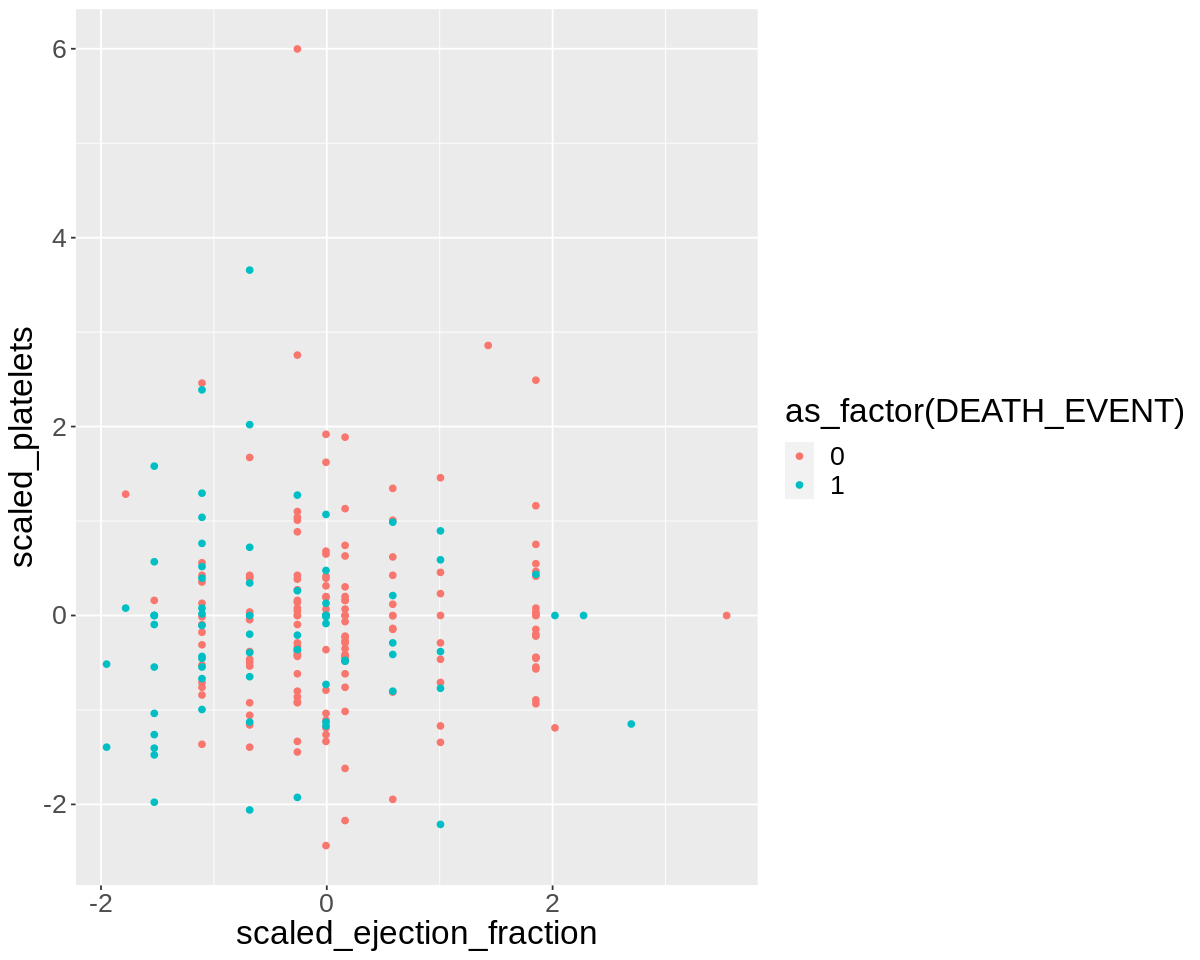

In [56]:
options(repr.plot.height = 8, repr.plot.width = 10)

plot_age_4 <- heart_data_train |>
    ggplot(aes(x = scaled_ejection_fraction, y = scaled_platelets, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20)) 
        
plot_age_4

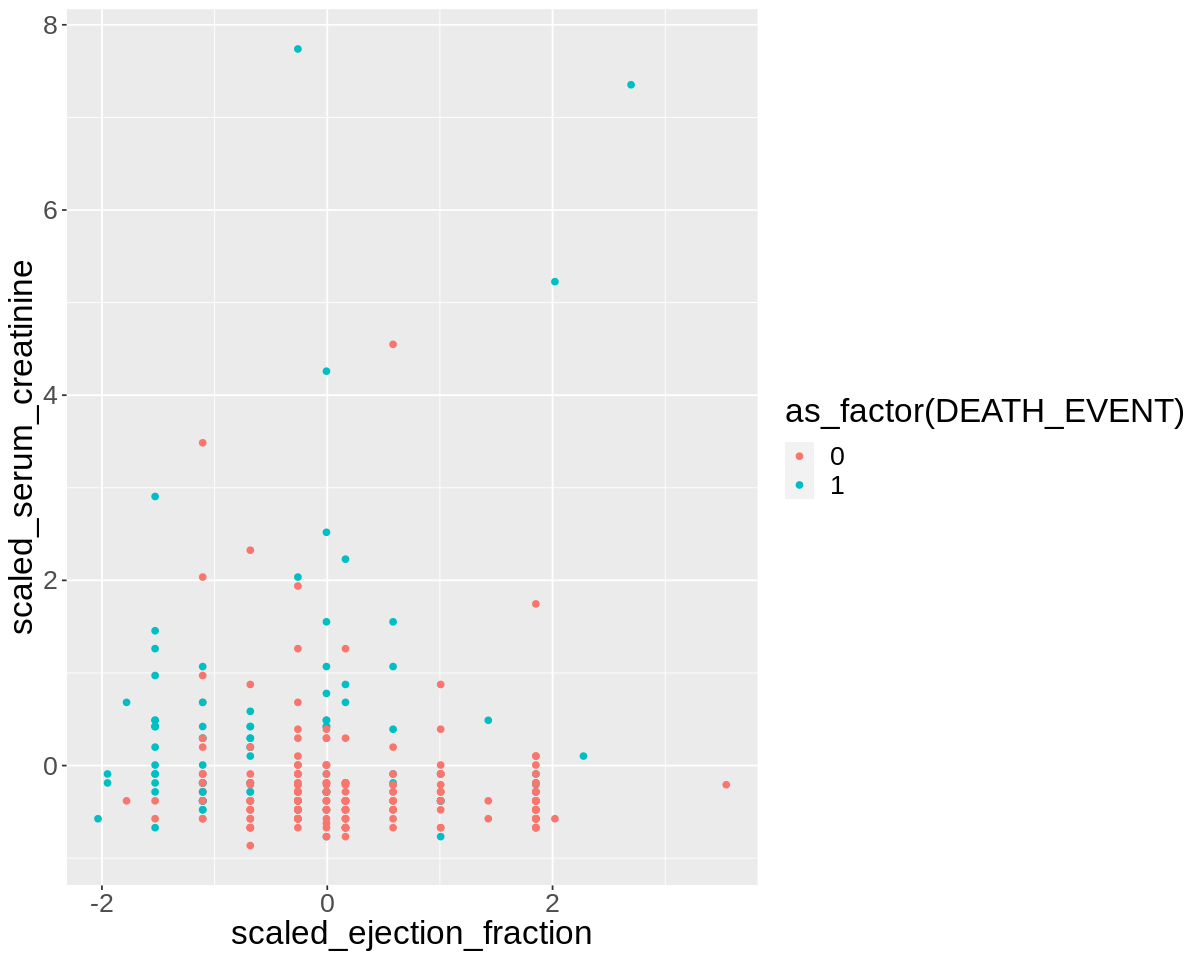

In [45]:
options(repr.plot.height = 8, repr.plot.width = 10)
plot_age_4 <- heart_data_scaled |>
    ggplot(aes(x = scaled_ejection_fraction, y = scaled_serum_creatinine, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20)) 
        
plot_age_4

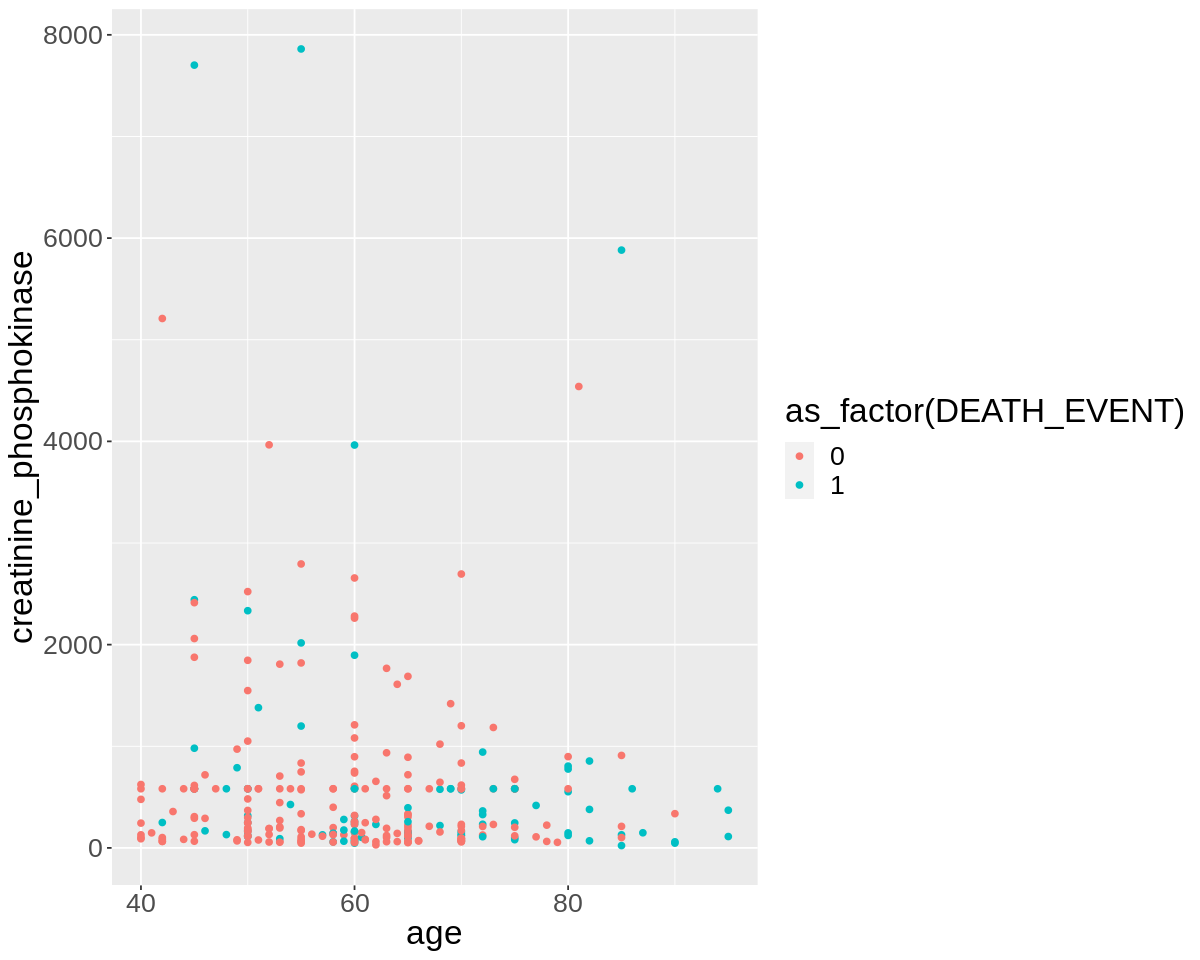

In [46]:
plot_age_1 <- heart_data |>
    ggplot(aes(x = age, y = creatinine_phosphokinase, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20)) 
        
plot_age_1

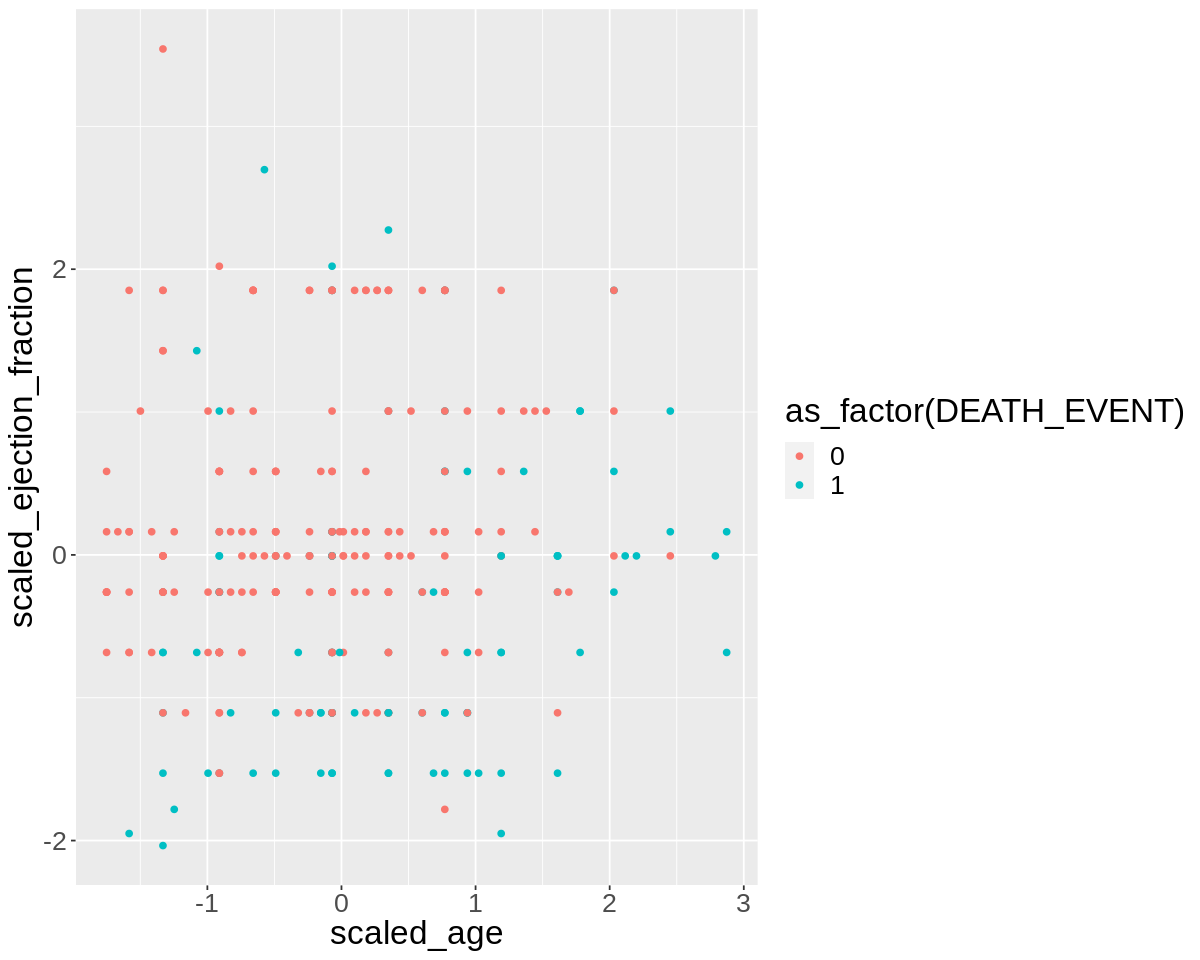

In [47]:
plot_age_2 <- heart_data_scaled |>
    ggplot(aes(x = scaled_age, y = scaled_ejection_fraction, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20)) 
        
plot_age_2

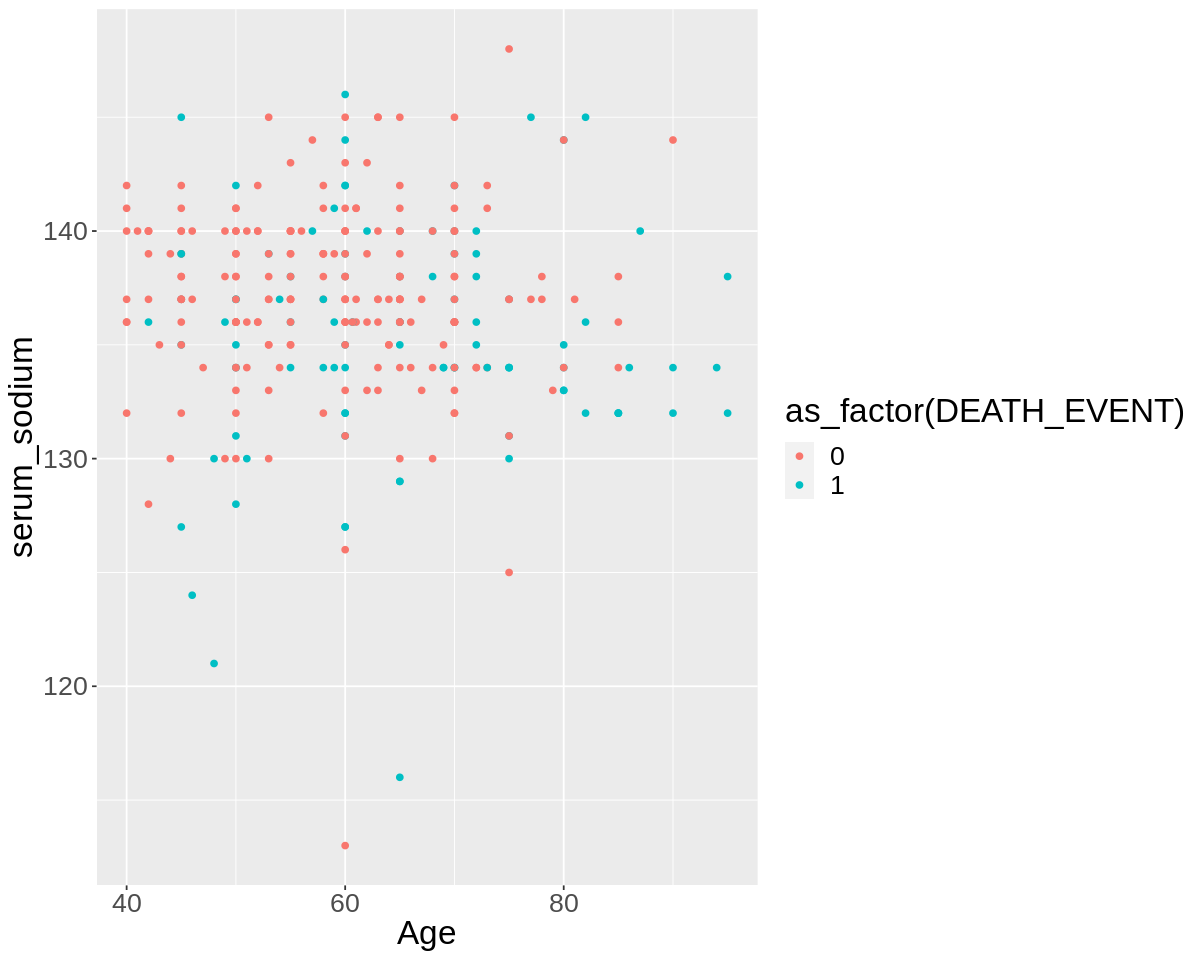

In [36]:
plot_age_3 <- heart_data_scaled |>
    ggplot(aes(x = age, y = serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Age", y = "serum_sodium")+
        theme(text = element_text(size = 20)) 
        
plot_age_3

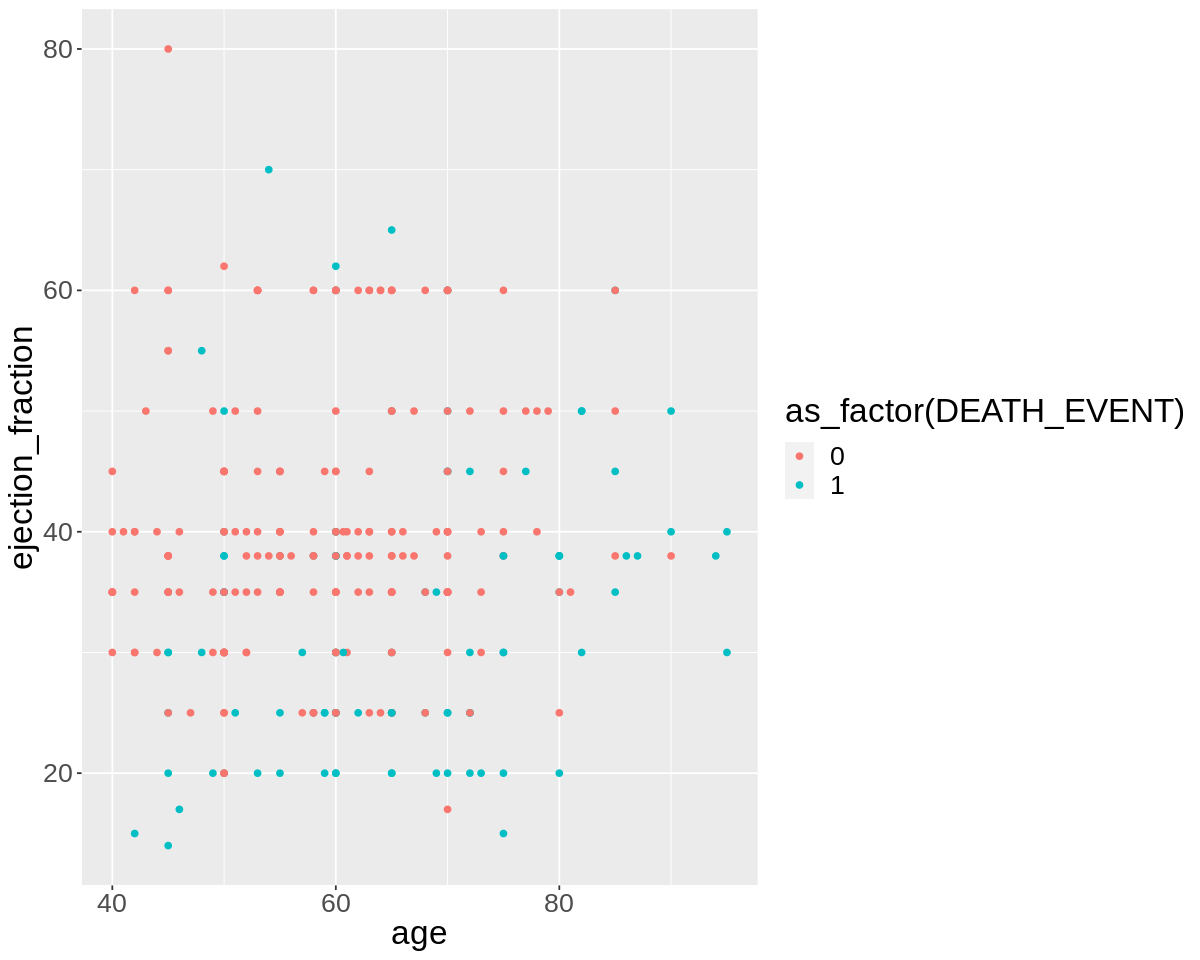

In [48]:
plot_creatinine_1 <- heart_data_scaled |>
    ggplot(aes(x = age, y = ejection_fraction, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20))
    
plot_creatinine_1

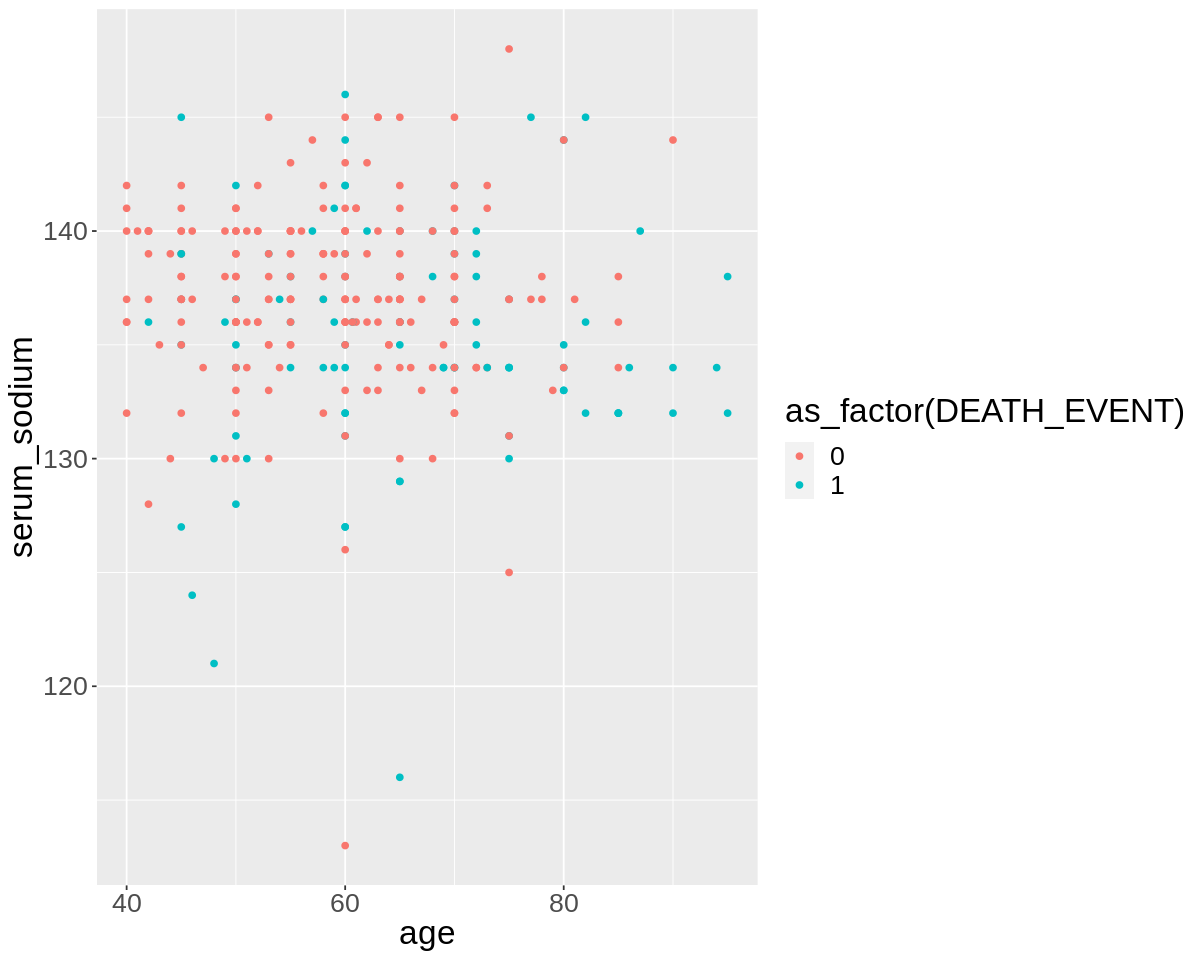

In [49]:
plot_creatinine_2 <- heart_data_scaled |>
    ggplot(aes(x = age, y = serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20))
    
plot_creatinine_2

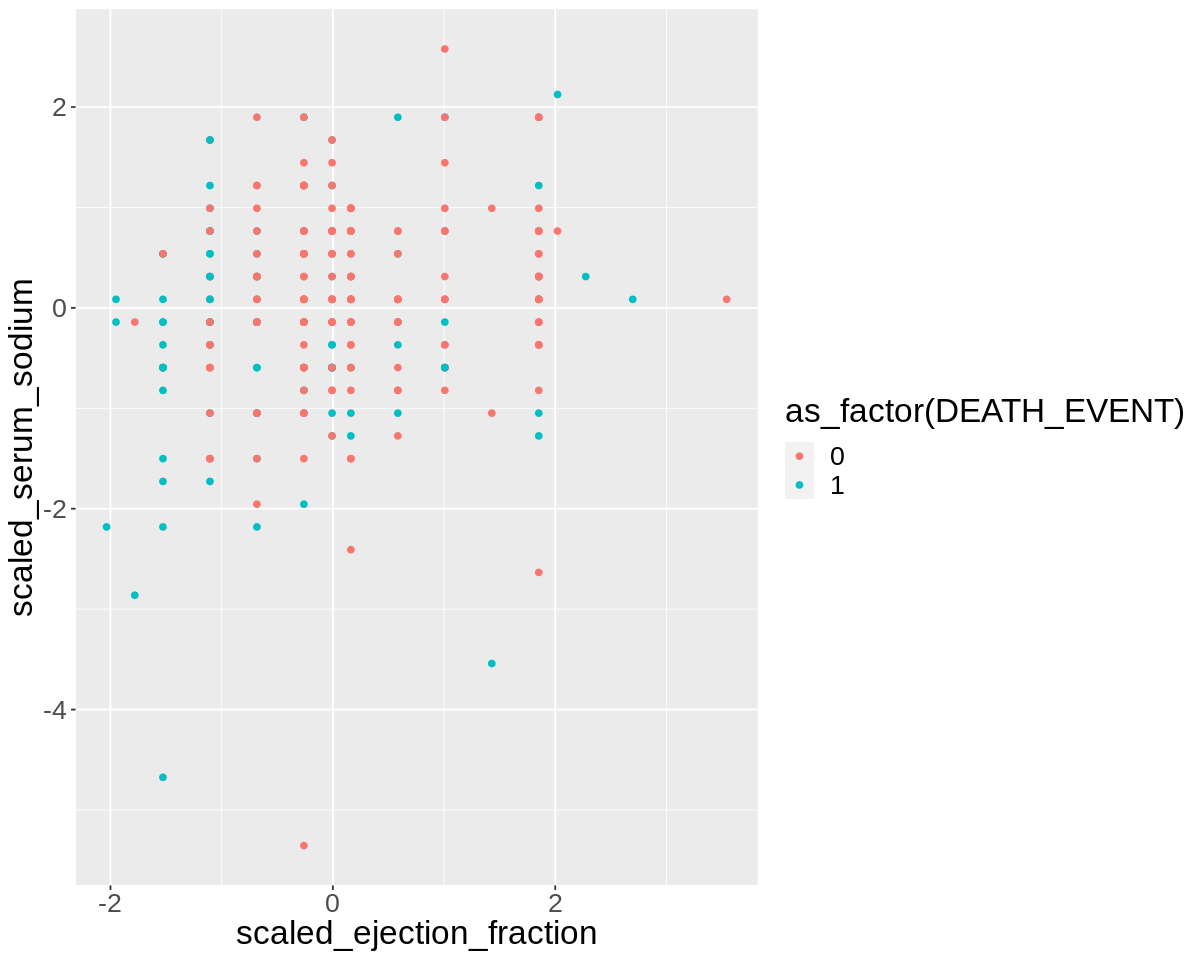

In [50]:
#options(repr.plot.height = 8, repr.plot.width = 10)
plot_ejection_fraction <- heart_data_scaled |>
    ggplot(aes(x = scaled_ejection_fraction, y = scaled_serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        theme(text = element_text(size = 20))
    
plot_ejection_fraction

## Expected outcomes and significance:

- **What do you expect to find?**
    
    We are expected to find if our model works well enough and is successful in predicting the relationship between different factors and how they
    affect death in the case of heart failure. For example, if a person with a high amount of ejection fraction is more or less likely to encounter 
    death upon undergoing heart failure. 
   
- **What impact could such findings have?**
    
    Finding the answer to such questions will allow us to control the variables which result in death in the case of heart failure, and minimize deaths
    which occur as a result of heart failure. This will have a huge impact as it can save numerous lives because heart failure is a leading cause of 
    death amongst adults.
    
- **What future questions could this lead to?**
    
    Some future questions which might potentially arise from this analysis are:
     
    1. How accurate is the analysis performed and how can the model be improved and refined in the future for results which are more 
          precise?
    2. Can such analysis and models be applied to different diseases across the medical field and help reduce the percentage of deaths 
          occuring overall? 